In [29]:
import sys,os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input,VGG16
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import plot_model,to_categorical
from glob import glob

In [30]:
BASE_DIRECTORY='/kaggle/input/flickr8k'
WORKING_DIRECTORY='/kaggle/working/'

In [31]:
#EXTRACT IMAGE FEATURES
model=VGG16()
#restructure
model=Model(inputs=model.input,outputs=model.layers[-2].output) 
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
model_img=model

In [ ]:
#extract feature from image
features={}
images=glob(BASE_DIRECTORY+'/Images/*.jpg')
for img in images:
    #load image
    image=load_img(img,target_size=(224,224))
    #convert to numpy array
    image=img_to_array(image)
    #reshape for vgg model
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    #preprocess
    input=preprocess_input(image)
    #extract feature
    feature=model.predict(image,verbose=0)
    #get id
    image_id=img.split('/')[-1].split('.')[0]
    #store features
    features[image_id]=feature

In [6]:
with open('/kaggle/input/feature-dict/feature_dict.pkl','rb') as f:
    features=pickle.load(f)

In [33]:
#loading captions
with open('/kaggle/input/flickr8k/captions.txt','r') as f:
    next(f)
    captions_doc=f.read()

In [34]:
#extract features from text
mapping={}
captions=captions_doc.split('\n')
for caption in captions:
    #separate image key
    line=caption.split(',')
    if len(line)<2:
        continue
    image_key=line[0].split('.')[0]
    text_value=line[1:]
    text_value=" ".join(text_value)
    if image_key not in mapping:
        mapping[image_key]=[]
    mapping[image_key].append(text_value)

In [35]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [36]:
#preprocess the text
def preprocess_caption(mapp):
    for image,captions in mapp.items():
        for i in range(len(captions)):
            caption=captions[i]
            #make all letter lower case
            caption=caption.lower()
            #eleminate all special charecters
            caption=caption.replace('[^a-z]','')
            #delete additional space
            caption=caption.replace('\s+',' ')
            #single letter words are removed
            caption=' '.join([word for word in caption.split() if len(word)>1])
            #addition od start and end
            caption='start '+caption+' end'
            captions[i]=caption

In [37]:
#preprocess the texts
preprocess_caption(mapping)

In [38]:
#all captions
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40455

In [39]:
#Tokenization
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [40]:
max_length=max([len(sentence.split()) for sentence in all_captions]) 

In [41]:
features['3226254560_2f8ac147ea'][0]

array([0.        , 1.230244  , 0.        , ..., 0.90312004, 1.0704045 ,
       0.        ], dtype=float32)

In [42]:
#data of definite atch size
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    n=0
    x1,x2,y=[],[],[]
    while True:
        for key in data_keys:
            n+=1
            for caption in mapping[key]:
                seq=tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq=seq[:i]
                    out_seq=seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,Y=np.array(x1),np.array(x2),np.array(y)
                yield [X1,X2],Y
                n=0
                x1,x2,y=[],[],[]

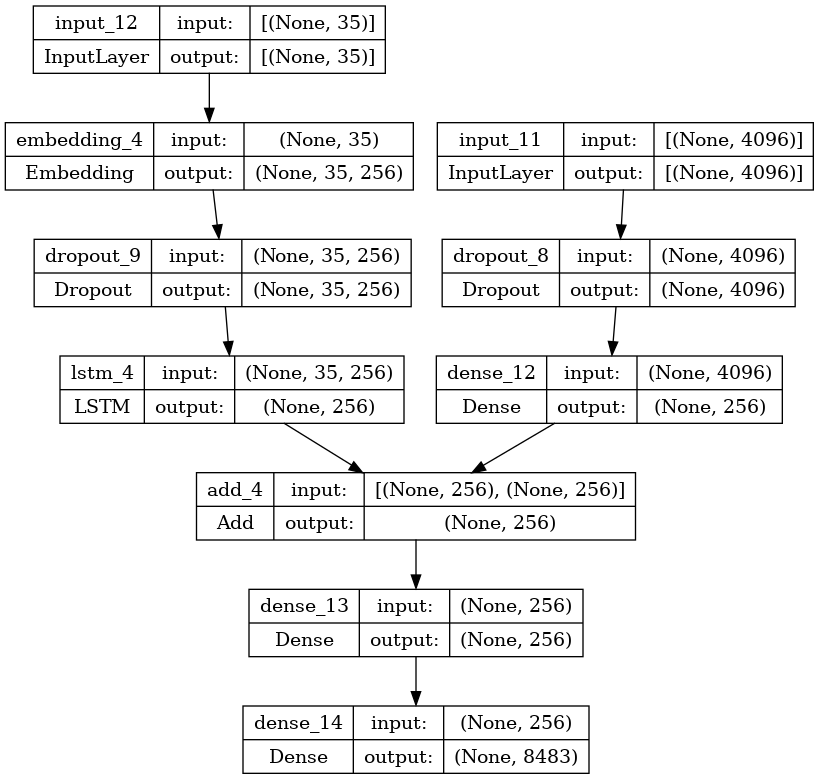

In [43]:
#model creation

#encoder model
#image feature layers
i1=Input(shape=(4096,))
x=Dropout(0.4)(i1)
imf=Dense(256,activation='relu')(x)
#sequence feature layers
i2=Input(shape=(max_length,))
x=Embedding(vocab_size,256,mask_zero=True)(i2)
x=Dropout(0.4)(x)
sf=LSTM(256)(x)

#decoder model
i=add([imf,sf])
x=Dense(256,activation='relu')(i)
output=Dense(vocab_size,activation='softmax')(x)

#finalize model
model=Model(inputs=[i1,i2],outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True,to_file='model.png')


In [44]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 35, 256)      2171648     ['input_12[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 4096)         0           ['input_11[0][0]']               
                                                                                            

In [45]:
#train_test_split
image_ids=list(features.keys())
size=int(len(image_ids)*0.9)
train=image_ids[:size]
test=image_ids[size:]

In [ ]:
#model run
epochs=20
batch_size=64
steps=len(train)//batch_size
for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [ ]:
model.save('/kaggle/working/best_model2.h5')

In [48]:
model=load_model('/kaggle/input/best-model/best_model.h5')

In [49]:
#generate caption for the image

#index to word converter
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if integer==index:
            return word
    return None

#generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
    in_seq='start'
    for i in range(max_length):
        seq=tokenizer.texts_to_sequences([in_seq])[0]
        seq=pad_sequences([seq],max_length)
        yhat=model.predict([image,seq],verbose=0)
        word_ind=np.argmax(yhat)
        pred_word=idx_to_word(word_ind,tokenizer)
        if pred_word==None:
            break
        in_seq+=" "+pred_word
        if pred_word=='end':
            break
    return in_seq

In [50]:
#validation with test data
actual,predicted=[],[]
for key in tqdm(test):
    captions=mapping[key]
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    actual_caption=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_caption)
    predicted.append(y_pred)
    
#calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu
print("BLEU-1 %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2 %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/2 [00:00<?, ?it/s]

BLEU-1 0.666055
BLEU-2 0.426854


--------------------------actual---------------------------
start "a group of people on the slopes person is skating boarding and bunch of people are surrounding him ." end
start airborne snowboarder in front of crowd end
start snowboarder in the air as others watch end
start snowboarder jumps high end
start snowboarder jumps while spectators watch end
--------------------------predicted------------------------
start snowboarder is flying through the air end


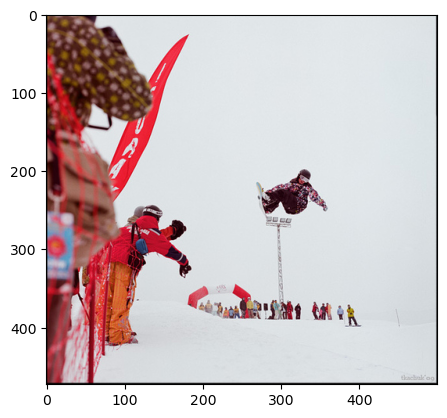

In [63]:
from PIL import Image
import matplotlib.pyplot as plt
image_name=np.random.choice(list(features.keys()))
image_path=f'/kaggle/input/flickr8k/Images/{image_name}.jpg'
image=Image.open(image_path)
captions=mapping[image_name]
print('--------------------------actual---------------------------')
for caption in captions:
    print(caption)
y_pred=predict_caption(model,features[image_name],tokenizer,max_length)
print('--------------------------predicted------------------------')
print(y_pred)
plt.imshow(image);          

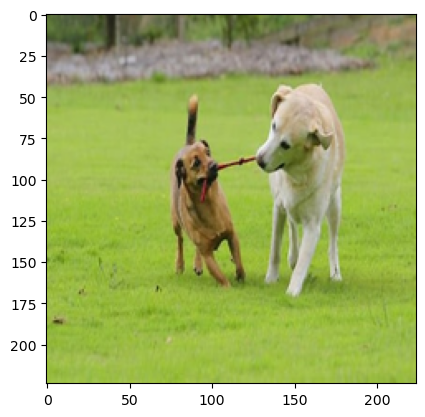

In [67]:
img=Image.open('/kaggle/input/dogs-image/dogs.jpg')
img=img.resize((224,224))
plt.imshow(img)
img=img_to_array(img)
img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
feature=model_img.predict(img,verbose=0)
features1=features.copy()

In [68]:
features1['dogs']=feature
y_pred=predict_caption(model,features1[image_name],tokenizer,max_length)

start white dog runs through the water end


TypeError: Invalid shape (1, 224, 224, 3) for image data

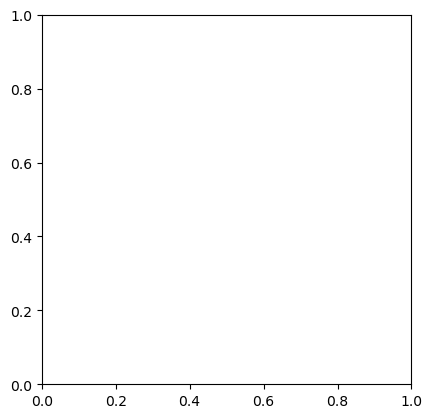

In [69]:
y_pred=predict_caption(model,features1['dogs'],tokenizer,max_length)
print(y_pred)
plt.imshow(img)